In [52]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [53]:
# Hyper parameters
########
num_of_feature = 8 # number of input features for LSTM and GRU network
past_observation = 24 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64, 32, 16]
return_sequence = [True, True, True, False]
batch_size = 64
num_of_epoch = 300



# Read dataset

In [54]:
# Import Dataset

traffic_data = pd.read_csv("dataset/Metro_Interstate_Traffic_Volume.csv")
traffic_data = traffic_data.set_index(pd.DatetimeIndex(traffic_data['date_time'])).rename(columns={"date_time": "ds"})
traffic_data['ds'] = pd.to_datetime(traffic_data['ds'],infer_datetime_format=True)

In [55]:
traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159


In [56]:
traffic_data = traffic_data.drop_duplicates()

In [57]:
# Checking for any missing or empty value
traffic_data.isna().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
ds                     0
traffic_volume         0
dtype: int64

# convert categorical to nominal data

In [58]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
traffic_data['weather_description'] = label_encoder.fit_transform(traffic_data['weather_description'])

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\1522180088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['holiday'] = np.where(traffic_data.holiday=='None',0,1).astype('int64')
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\1522180088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data['weather_main'] = label_encoder.fit_transform(traffic_data['weather_main'])
C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\1522180088.py:5: SettingWithCopyWarning: 
A value 

In [59]:
traffic_data.describe()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
count,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000,48187.000000
mean,0.001266,281.204995,0.334382,0.000222,49.365451,2.578642,16.540021,3259.618134
std,0.035557,13.338738,44.797033,0.008169,39.015213,2.784148,8.969561,1986.954465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,272.160000,0.000000,0.000000,1.000000,0.000000,10.000000,1192.500000
50%,0.000000,282.450000,0.000000,0.000000,64.000000,1.000000,17.000000,3379.000000
75%,0.000000,291.806000,0.000000,0.000000,90.000000,5.000000,27.000000,4933.000000
max,1.000000,310.070000,9831.300000,0.510000,100.000000,10.000000,37.000000,7280.000000


<AxesSubplot:xlabel='date_time'>

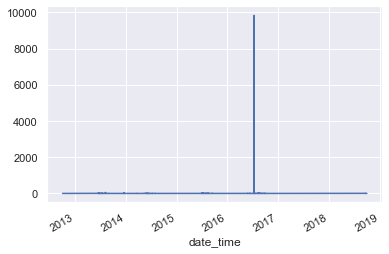

In [60]:
#traffic_data['temp'].plot()
traffic_data['rain_1h'].plot()


<AxesSubplot:xlabel='date_time'>

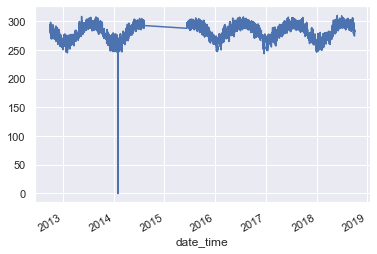

In [61]:
traffic_data['temp'].plot()

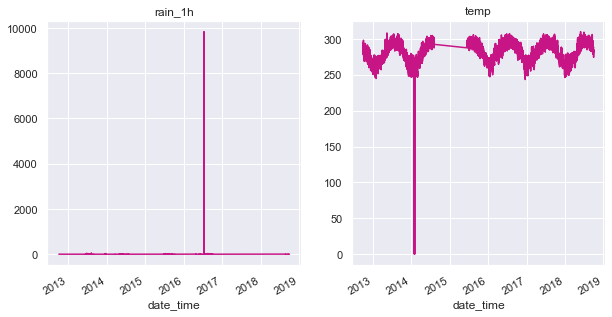

In [62]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("images/with_outlier.png", dpi=1200)

In [63]:
Q1 = traffic_data.quantile(0.25)
Q3 = traffic_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

holiday                   0.000
temp                     19.646
rain_1h                   0.000
snow_1h                   0.000
clouds_all               89.000
weather_main              5.000
weather_description      17.000
traffic_volume         3740.500
dtype: float64


In [64]:
traffic_data=traffic_data[~((traffic_data['temp'] <(Q1['temp']-1.5*IQR['temp'])) | (traffic_data['temp'] >(Q1['temp']+1.5*IQR['temp'])))]
traffic_data=traffic_data[~((traffic_data['traffic_volume'] <(Q1['traffic_volume']-1.5*IQR['traffic_volume'])) | (traffic_data['traffic_volume'] >(Q1['traffic_volume']+1.5*IQR['traffic_volume'])))]

# Prepare training and testing data

<AxesSubplot:xlabel='date_time'>

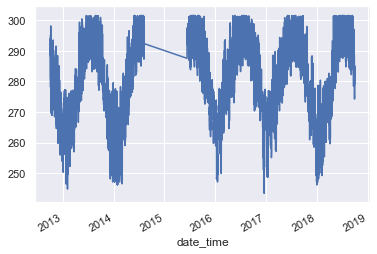

In [65]:
# ploting traffic data to see to see any data imbalance
traffic_data['temp'].plot()

<AxesSubplot:xlabel='date_time'>

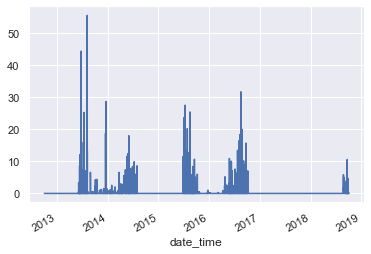

In [66]:
traffic_data['rain_1h'].plot()

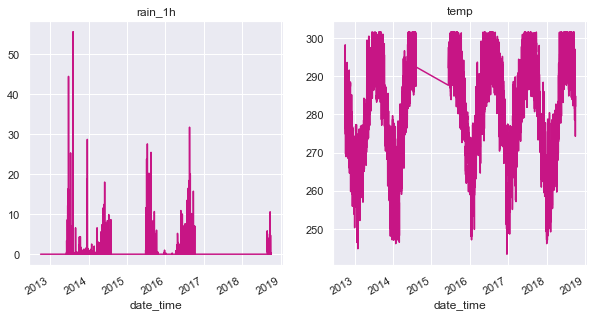

In [67]:
df1 = traffic_data['rain_1h']
df2 = traffic_data['temp']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['rain_1h','temp']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1
plt.savefig("images/without_outlier.png", dpi=1200)

In [68]:

traffic_data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2012-10-02 09:00:00,0,288.28,0.0,0.0,40,1,24,2012-10-02 09:00:00,5545
2012-10-02 10:00:00,0,289.36,0.0,0.0,75,1,2,2012-10-02 10:00:00,4516
2012-10-02 11:00:00,0,289.58,0.0,0.0,90,1,19,2012-10-02 11:00:00,4767
2012-10-02 12:00:00,0,290.13,0.0,0.0,90,1,19,2012-10-02 12:00:00,5026
2012-10-02 13:00:00,0,291.14,0.0,0.0,75,1,2,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,0.0,0.0,75,1,2,2018-09-30 19:00:00,3543
2018-09-30 20:00:00,0,282.76,0.0,0.0,90,1,19,2018-09-30 20:00:00,2781
2018-09-30 21:00:00,0,282.73,0.0,0.0,90,10,21,2018-09-30 21:00:00,2159


In [69]:
split_date = '2018-01-01'
train_data = traffic_data.loc[traffic_data.index <= split_date].copy()
test_data = traffic_data.loc[traffic_data.index > split_date].copy()

In [70]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)

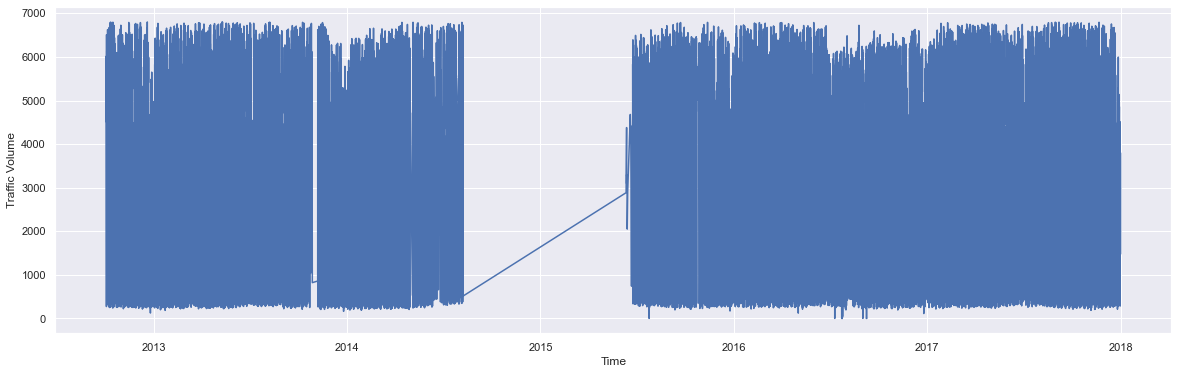

In [71]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(20,6))
plot_series(time_train, x_train)

In [72]:
train_data_without_ds = train_data.drop(columns=['ds'])
train_data_without_ds
test_data_without_ds = test_data.drop(columns=['ds'])
test_data_without_ds

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2018-01-01 01:00:00,0,249.08,0.0,0.0,1,0,27,1408
2018-01-01 02:00:00,0,248.86,0.0,0.0,1,0,27,931
2018-01-01 03:00:00,0,248.72,0.0,0.0,1,0,27,585
2018-01-01 04:00:00,0,248.43,0.0,0.0,1,0,27,381
2018-01-01 05:00:00,0,248.07,0.0,0.0,1,0,27,434
...,...,...,...,...,...,...,...,...
2018-09-30 19:00:00,0,283.45,0.0,0.0,75,1,2,3543
2018-09-30 20:00:00,0,282.76,0.0,0.0,90,1,19,2781
2018-09-30 21:00:00,0,282.73,0.0,0.0,90,10,21,2159


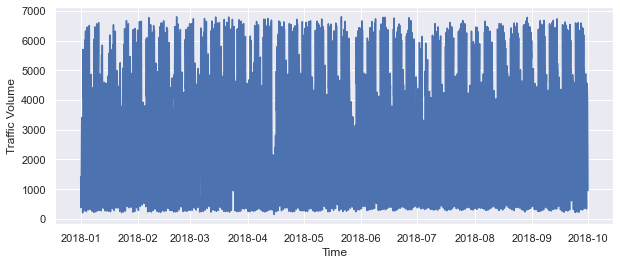

In [73]:
x_train = np.array(train_data['traffic_volume'])
x_valid = np.array(test_data['traffic_volume'])

time_train = np.array(train_data['ds'])
time_valid = np.array(test_data['ds'])

plt.figure(figsize=(10,4))
plot_series(time_valid, x_valid)

In [74]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data_without_ds)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data_without_ds)
test_data_frame = pd.DataFrame(test_data_set)


In [75]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((39356, 24, 8), (39356,))

In [76]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((7604, 24, 8), (7604,))

In [77]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.9) # 80% trainging
validation_length = int(len(X)*.10) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

35420 3935 39355


In [78]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((35420, 24, 8), (35420,)), ((3936, 24, 8), (3936,)))

In [79]:
#define LSTM model:


LSTM_Model = Sequential()
LSTM_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
LSTM_Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 128)           70144     
                                                                 
 lstm_5 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_6 (LSTM)               (None, 24, 32)            12416     
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 135,121
Trainable params: 135,121
Non-trainable params: 0
_________________________________________________________________


In [80]:
#Define GRU MODEL
GRU_Model = Sequential()
GRU_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
GRU_Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 24, 128)           52992     
                                                                 
 gru_5 (GRU)                 (None, 24, 64)            37248     
                                                                 
 gru_6 (GRU)                 (None, 24, 32)            9408      
                                                                 
 gru_7 (GRU)                 (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 102,065
Trainable params: 102,065
Non-trainable params: 0
_________________________________________________________________


In [81]:
LSTM_CheckPoint = ModelCheckpoint('model/model_lstm/', save_best_only=True)
GRU_CheckPoint = ModelCheckpoint('model/model_gru/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, mode='min')


In [82]:
# Train LSTM Model
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=1)

Epoch 1/300
552/554 [============================>.] - ETA: 0s - loss: 0.0813 - mean_absolute_error: 0.2423 - mean_absolute_percentage_error: 32734.4863

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 32s 50ms/step - loss: 0.0813 - mean_absolute_error: 0.2422 - mean_absolute_percentage_error: 32649.7578 - val_loss: 0.0548 - val_mean_absolute_error: 0.1891 - val_mean_absolute_percentage_error: 121.5357
Epoch 2/300
553/554 [============================>.] - ETA: 0s - loss: 0.0501 - mean_absolute_error: 0.1762 - mean_absolute_percentage_error: 22554.1973

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 47ms/step - loss: 0.0501 - mean_absolute_error: 0.1762 - mean_absolute_percentage_error: 22536.4336 - val_loss: 0.0322 - val_mean_absolute_error: 0.1380 - val_mean_absolute_percentage_error: 60.7700
Epoch 3/300
554/554 [==============================] - ETA: 0s - loss: 0.0322 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 14446.8359

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 27s 48ms/step - loss: 0.0322 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 14446.8359 - val_loss: 0.0197 - val_mean_absolute_error: 0.1052 - val_mean_absolute_percentage_error: 38.5558
Epoch 4/300
554/554 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.1095 - mean_absolute_percentage_error: 10154.4854

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 47ms/step - loss: 0.0216 - mean_absolute_error: 0.1095 - mean_absolute_percentage_error: 10154.4854 - val_loss: 0.0124 - val_mean_absolute_error: 0.0806 - val_mean_absolute_percentage_error: 29.2609
Epoch 5/300
554/554 [==============================] - ETA: 0s - loss: 0.0152 - mean_absolute_error: 0.0896 - mean_absolute_percentage_error: 7679.0308

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 27s 49ms/step - loss: 0.0152 - mean_absolute_error: 0.0896 - mean_absolute_percentage_error: 7679.0308 - val_loss: 0.0108 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error: 31.6447
Epoch 6/300
554/554 [==============================] - ETA: 0s - loss: 0.0117 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 6291.5972

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 47ms/step - loss: 0.0117 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 6291.5972 - val_loss: 0.0069 - val_mean_absolute_error: 0.0609 - val_mean_absolute_percentage_error: 23.5533
Epoch 7/300
553/554 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 6004.5527

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 27s 50ms/step - loss: 0.0102 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 5999.8315 - val_loss: 0.0062 - val_mean_absolute_error: 0.0579 - val_mean_absolute_percentage_error: 24.4961
Epoch 8/300
554/554 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 3815.6663

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 47ms/step - loss: 0.0094 - mean_absolute_error: 0.0658 - mean_absolute_percentage_error: 3815.6663 - val_loss: 0.0057 - val_mean_absolute_error: 0.0533 - val_mean_absolute_percentage_error: 19.5078
Epoch 9/300
554/554 [==============================] - 14s 25ms/step - loss: 0.0093 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 4699.9307 - val_loss: 0.0065 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 22.6066
Epoch 10/300
552/554 [============================>.] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 4139.9321

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0091 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 4129.2573 - val_loss: 0.0054 - val_mean_absolute_error: 0.0531 - val_mean_absolute_percentage_error: 20.4600
Epoch 11/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0089 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 2699.1384 - val_loss: 0.0058 - val_mean_absolute_error: 0.0571 - val_mean_absolute_percentage_error: 21.6484
Epoch 12/300
552/554 [============================>.] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 2502.7686

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 46ms/step - loss: 0.0089 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 2496.3245 - val_loss: 0.0052 - val_mean_absolute_error: 0.0523 - val_mean_absolute_percentage_error: 19.7736
Epoch 13/300
554/554 [==============================] - 14s 25ms/step - loss: 0.0088 - mean_absolute_error: 0.0629 - mean_absolute_percentage_error: 3104.9402 - val_loss: 0.0053 - val_mean_absolute_error: 0.0522 - val_mean_absolute_percentage_error: 17.2834
Epoch 14/300
554/554 [==============================] - 14s 26ms/step - loss: 0.0086 - mean_absolute_error: 0.0620 - mean_absolute_percentage_error: 4000.1350 - val_loss: 0.0052 - val_mean_absolute_error: 0.0534 - val_mean_absolute_percentage_error: 20.1132
Epoch 15/300
554/554 [==============================] - 14s 26ms/step - loss: 0.0084 - mean_absolute_error: 0.0609 - mean_absolute_percentage_error: 4160.6548 - val_loss: 0.0061 - val_mean_absolute_error: 0.0594 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 46ms/step - loss: 0.0083 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 3559.1316 - val_loss: 0.0047 - val_mean_absolute_error: 0.0494 - val_mean_absolute_percentage_error: 18.5957
Epoch 18/300
554/554 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 3127.3521

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 27s 48ms/step - loss: 0.0081 - mean_absolute_error: 0.0597 - mean_absolute_percentage_error: 3127.3521 - val_loss: 0.0046 - val_mean_absolute_error: 0.0484 - val_mean_absolute_percentage_error: 17.4773
Epoch 19/300
554/554 [==============================] - 14s 25ms/step - loss: 0.0080 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 2102.4995 - val_loss: 0.0049 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 18.1389
Epoch 20/300
554/554 [==============================] - 14s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 2774.0303 - val_loss: 0.0048 - val_mean_absolute_error: 0.0511 - val_mean_absolute_percentage_error: 21.7493
Epoch 21/300
554/554 [==============================] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 2016.7334

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 47ms/step - loss: 0.0078 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 2016.7334 - val_loss: 0.0045 - val_mean_absolute_error: 0.0483 - val_mean_absolute_percentage_error: 17.6492
Epoch 22/300
554/554 [==============================] - 14s 26ms/step - loss: 0.0077 - mean_absolute_error: 0.0580 - mean_absolute_percentage_error: 1340.0173 - val_loss: 0.0045 - val_mean_absolute_error: 0.0487 - val_mean_absolute_percentage_error: 20.2251
Epoch 23/300
553/554 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 2876.2200

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 46ms/step - loss: 0.0077 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 2873.9587 - val_loss: 0.0042 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 15.6161
Epoch 24/300
554/554 [==============================] - 15s 27ms/step - loss: 0.0076 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 2894.9307 - val_loss: 0.0043 - val_mean_absolute_error: 0.0471 - val_mean_absolute_percentage_error: 16.2722
Epoch 25/300
554/554 [==============================] - 13s 24ms/step - loss: 0.0075 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 3121.9131 - val_loss: 0.0043 - val_mean_absolute_error: 0.0468 - val_mean_absolute_percentage_error: 18.2889
Epoch 26/300
553/554 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 2172.2620

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 46ms/step - loss: 0.0074 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 2170.5583 - val_loss: 0.0041 - val_mean_absolute_error: 0.0458 - val_mean_absolute_percentage_error: 16.1083
Epoch 27/300
554/554 [==============================] - 14s 26ms/step - loss: 0.0074 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 4833.8105 - val_loss: 0.0050 - val_mean_absolute_error: 0.0529 - val_mean_absolute_percentage_error: 18.8277
Epoch 28/300
554/554 [==============================] - 15s 27ms/step - loss: 0.0073 - mean_absolute_error: 0.0561 - mean_absolute_percentage_error: 4205.1221 - val_loss: 0.0042 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 15.1426
Epoch 29/300
554/554 [==============================] - 14s 25ms/step - loss: 0.0072 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 3459.6848 - val_loss: 0.0042 - val_mean_absolute_error: 0.0469 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 45ms/step - loss: 0.0071 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 4955.7148 - val_loss: 0.0041 - val_mean_absolute_error: 0.0453 - val_mean_absolute_percentage_error: 16.2598
Epoch 31/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0549 - mean_absolute_percentage_error: 4578.9043 - val_loss: 0.0044 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 16.7749
Epoch 32/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 2347.8765 - val_loss: 0.0041 - val_mean_absolute_error: 0.0461 - val_mean_absolute_percentage_error: 16.9785
Epoch 33/300
554/554 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 1789.1251

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0070 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 1789.1251 - val_loss: 0.0040 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 17.2364
Epoch 34/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 4146.4399 - val_loss: 0.0042 - val_mean_absolute_error: 0.0480 - val_mean_absolute_percentage_error: 20.8144
Epoch 35/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0070 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 3604.1238 - val_loss: 0.0042 - val_mean_absolute_error: 0.0465 - val_mean_absolute_percentage_error: 14.8201
Epoch 36/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0069 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 2096.4543 - val_loss: 0.0043 - val_mean_absolute_error: 0.0477 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0069 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 2991.1450 - val_loss: 0.0038 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percentage_error: 15.9897
Epoch 38/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 4154.2212 - val_loss: 0.0039 - val_mean_absolute_error: 0.0447 - val_mean_absolute_percentage_error: 17.2109
Epoch 39/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 2768.5828 - val_loss: 0.0040 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 15.7782
Epoch 40/300
554/554 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 4373.9463

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0068 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 4373.9463 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 15.8925
Epoch 41/300
554/554 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 2812.6711

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 44ms/step - loss: 0.0067 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 2812.6711 - val_loss: 0.0037 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 14.3824
Epoch 42/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0067 - mean_absolute_error: 0.0527 - mean_absolute_percentage_error: 2248.3049 - val_loss: 0.0038 - val_mean_absolute_error: 0.0433 - val_mean_absolute_percentage_error: 14.0615
Epoch 43/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0067 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 3293.3530 - val_loss: 0.0038 - val_mean_absolute_error: 0.0440 - val_mean_absolute_percentage_error: 14.5432
Epoch 44/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0066 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 2339.6145 - val_loss: 0.0039 - val_mean_absolute_error: 0.0450 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 24s 44ms/step - loss: 0.0065 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 4185.1099 - val_loss: 0.0036 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 13.9031
Epoch 50/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0065 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 1997.7777 - val_loss: 0.0036 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 14.0389
Epoch 51/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0064 - mean_absolute_error: 0.0514 - mean_absolute_percentage_error: 1943.5824 - val_loss: 0.0037 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 14.4962
Epoch 52/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0064 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 3147.6353 - val_loss: 0.0038 - val_mean_absolute_error: 0.0450 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0064 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 2982.7751 - val_loss: 0.0036 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 14.2536
Epoch 55/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0063 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 2155.5291 - val_loss: 0.0037 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 15.2639
Epoch 56/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0063 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 1692.9243 - val_loss: 0.0039 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 15.1426
Epoch 57/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0063 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 2454.4822 - val_loss: 0.0039 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0062 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 2995.9351 - val_loss: 0.0035 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 15.1484
Epoch 62/300
554/554 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 1884.2869

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 25s 45ms/step - loss: 0.0062 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 1884.2869 - val_loss: 0.0035 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 13.2498
Epoch 63/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0500 - mean_absolute_percentage_error: 809.3383 - val_loss: 0.0036 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 16.0215
Epoch 64/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 1118.2472 - val_loss: 0.0035 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 14.4942
Epoch 65/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0500 - mean_absolute_percentage_error: 805.3453 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentag

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0061 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 3806.6287 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409 - val_mean_absolute_percentage_error: 14.3444
Epoch 69/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0060 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 1557.7905 - val_loss: 0.0035 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 14.5608
Epoch 70/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0060 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 1522.0919 - val_loss: 0.0034 - val_mean_absolute_error: 0.0411 - val_mean_absolute_percentage_error: 14.6439
Epoch 71/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0060 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 885.5258 - val_loss: 0.0035 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percenta

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0059 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 1963.1704 - val_loss: 0.0034 - val_mean_absolute_error: 0.0406 - val_mean_absolute_percentage_error: 13.5133
Epoch 77/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0058 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 930.8808 - val_loss: 0.0035 - val_mean_absolute_error: 0.0417 - val_mean_absolute_percentage_error: 13.6855
Epoch 78/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0058 - mean_absolute_error: 0.0487 - mean_absolute_percentage_error: 2605.9504 - val_loss: 0.0034 - val_mean_absolute_error: 0.0408 - val_mean_absolute_percentage_error: 13.8244
Epoch 79/300
554/554 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 853.6679

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0058 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 853.6679 - val_loss: 0.0034 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 14.3636
Epoch 80/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0058 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 1429.6755 - val_loss: 0.0036 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 13.3119
Epoch 81/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 1782.8600 - val_loss: 0.0035 - val_mean_absolute_error: 0.0408 - val_mean_absolute_percentage_error: 14.5653
Epoch 82/300
553/554 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 517.9213

INFO:tensorflow:Assets written to: model/model_lstm\assets


INFO:tensorflow:Assets written to: model/model_lstm\assets


554/554 [==============================] - 26s 48ms/step - loss: 0.0057 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 517.5245 - val_loss: 0.0033 - val_mean_absolute_error: 0.0399 - val_mean_absolute_percentage_error: 13.2953
Epoch 83/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 2104.5986 - val_loss: 0.0034 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 13.7291
Epoch 84/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0057 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 1191.7594 - val_loss: 0.0035 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 13.6506
Epoch 85/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 1476.7115 - val_loss: 0.0033 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percenta

In [83]:
# Train GRU Model
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=1)

Epoch 1/300
554/554 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.1739 - mean_absolute_percentage_error: 15880.2578

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 28s 43ms/step - loss: 0.0482 - mean_absolute_error: 0.1739 - mean_absolute_percentage_error: 15880.2578 - val_loss: 0.0163 - val_mean_absolute_error: 0.1005 - val_mean_absolute_percentage_error: 46.7728
Epoch 2/300
552/554 [============================>.] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 7724.6294

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 39ms/step - loss: 0.0135 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 7704.6387 - val_loss: 0.0077 - val_mean_absolute_error: 0.0672 - val_mean_absolute_percentage_error: 31.5466
Epoch 3/300
554/554 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 6487.8516

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0111 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 6487.8516 - val_loss: 0.0071 - val_mean_absolute_error: 0.0628 - val_mean_absolute_percentage_error: 27.2945
Epoch 4/300
552/554 [============================>.] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 5455.1997

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0106 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 5441.0791 - val_loss: 0.0068 - val_mean_absolute_error: 0.0603 - val_mean_absolute_percentage_error: 25.5184
Epoch 5/300
553/554 [============================>.] - ETA: 0s - loss: 0.0102 - mean_absolute_error: 0.0693 - mean_absolute_percentage_error: 5922.2456

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 39ms/step - loss: 0.0102 - mean_absolute_error: 0.0693 - mean_absolute_percentage_error: 5917.5850 - val_loss: 0.0064 - val_mean_absolute_error: 0.0589 - val_mean_absolute_percentage_error: 24.6928
Epoch 6/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0098 - mean_absolute_error: 0.0677 - mean_absolute_percentage_error: 6058.1465 - val_loss: 0.0066 - val_mean_absolute_error: 0.0609 - val_mean_absolute_percentage_error: 28.2280
Epoch 7/300
554/554 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 4149.6846

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0097 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 4149.6846 - val_loss: 0.0061 - val_mean_absolute_error: 0.0580 - val_mean_absolute_percentage_error: 25.5269
Epoch 8/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0095 - mean_absolute_error: 0.0669 - mean_absolute_percentage_error: 4481.4175 - val_loss: 0.0064 - val_mean_absolute_error: 0.0607 - val_mean_absolute_percentage_error: 25.5343
Epoch 9/300
551/554 [============================>.] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 3522.2419

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0094 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 3506.9478 - val_loss: 0.0060 - val_mean_absolute_error: 0.0580 - val_mean_absolute_percentage_error: 23.9350
Epoch 10/300
552/554 [============================>.] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 2250.5479

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0093 - mean_absolute_error: 0.0657 - mean_absolute_percentage_error: 2244.7729 - val_loss: 0.0059 - val_mean_absolute_error: 0.0578 - val_mean_absolute_percentage_error: 25.2481
Epoch 11/300
551/554 [============================>.] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 3208.4827

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0091 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 3194.4719 - val_loss: 0.0058 - val_mean_absolute_error: 0.0565 - val_mean_absolute_percentage_error: 22.5206
Epoch 12/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0090 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 2623.0205 - val_loss: 0.0062 - val_mean_absolute_error: 0.0584 - val_mean_absolute_percentage_error: 19.8708
Epoch 13/300
554/554 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 862.7581

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0088 - mean_absolute_error: 0.0632 - mean_absolute_percentage_error: 862.7581 - val_loss: 0.0054 - val_mean_absolute_error: 0.0531 - val_mean_absolute_percentage_error: 18.5343
Epoch 14/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0086 - mean_absolute_error: 0.0624 - mean_absolute_percentage_error: 658.7922 - val_loss: 0.0056 - val_mean_absolute_error: 0.0550 - val_mean_absolute_percentage_error: 22.0744
Epoch 15/300
553/554 [============================>.] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.0615 - mean_absolute_percentage_error: 1507.9938

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0085 - mean_absolute_error: 0.0615 - mean_absolute_percentage_error: 1506.8187 - val_loss: 0.0051 - val_mean_absolute_error: 0.0517 - val_mean_absolute_percentage_error: 17.1983
Epoch 16/300
554/554 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 1116.9575

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0083 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 1116.9575 - val_loss: 0.0050 - val_mean_absolute_error: 0.0511 - val_mean_absolute_percentage_error: 17.6344
Epoch 17/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0081 - mean_absolute_error: 0.0598 - mean_absolute_percentage_error: 670.3420 - val_loss: 0.0053 - val_mean_absolute_error: 0.0542 - val_mean_absolute_percentage_error: 21.1683
Epoch 18/300
552/554 [============================>.] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 920.6972

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0080 - mean_absolute_error: 0.0591 - mean_absolute_percentage_error: 918.3763 - val_loss: 0.0047 - val_mean_absolute_error: 0.0493 - val_mean_absolute_percentage_error: 18.1304
Epoch 19/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0079 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 1850.4967 - val_loss: 0.0048 - val_mean_absolute_error: 0.0508 - val_mean_absolute_percentage_error: 18.8307
Epoch 20/300
553/554 [============================>.] - ETA: 0s - loss: 0.0078 - mean_absolute_error: 0.0583 - mean_absolute_percentage_error: 630.5029

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0078 - mean_absolute_error: 0.0583 - mean_absolute_percentage_error: 630.0212 - val_loss: 0.0047 - val_mean_absolute_error: 0.0489 - val_mean_absolute_percentage_error: 16.2469
Epoch 21/300
552/554 [============================>.] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 1900.0585

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0077 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 1895.1666 - val_loss: 0.0045 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 16.0008
Epoch 22/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0076 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 1353.3119 - val_loss: 0.0046 - val_mean_absolute_error: 0.0493 - val_mean_absolute_percentage_error: 15.8944
Epoch 23/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0075 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 1829.8914 - val_loss: 0.0047 - val_mean_absolute_error: 0.0498 - val_mean_absolute_percentage_error: 19.3875
Epoch 24/300
553/554 [============================>.] - ETA: 0s - loss: 0.0074 - mean_absolute_error: 0.0567 - mean_absolute_percentage_error: 2141.7351

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0074 - mean_absolute_error: 0.0567 - mean_absolute_percentage_error: 2140.0576 - val_loss: 0.0043 - val_mean_absolute_error: 0.0467 - val_mean_absolute_percentage_error: 16.3577
Epoch 25/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0073 - mean_absolute_error: 0.0562 - mean_absolute_percentage_error: 1830.6849 - val_loss: 0.0043 - val_mean_absolute_error: 0.0471 - val_mean_absolute_percentage_error: 16.0406
Epoch 26/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0073 - mean_absolute_error: 0.0559 - mean_absolute_percentage_error: 2502.2188 - val_loss: 0.0044 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 17.8114
Epoch 27/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0072 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 1831.7729 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0072 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 2755.3684 - val_loss: 0.0042 - val_mean_absolute_error: 0.0467 - val_mean_absolute_percentage_error: 17.2287
Epoch 29/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0071 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 3026.9722 - val_loss: 0.0043 - val_mean_absolute_error: 0.0473 - val_mean_absolute_percentage_error: 17.5771
Epoch 30/300
552/554 [============================>.] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.0549 - mean_absolute_percentage_error: 2278.0952

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 21s 38ms/step - loss: 0.0071 - mean_absolute_error: 0.0549 - mean_absolute_percentage_error: 2272.2253 - val_loss: 0.0042 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 15.1214
Epoch 31/300
553/554 [============================>.] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 1994.0300

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0070 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 1992.5663 - val_loss: 0.0040 - val_mean_absolute_error: 0.0444 - val_mean_absolute_percentage_error: 14.8372
Epoch 32/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0070 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 2638.0364 - val_loss: 0.0043 - val_mean_absolute_error: 0.0472 - val_mean_absolute_percentage_error: 15.9037
Epoch 33/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0069 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 2700.8018 - val_loss: 0.0043 - val_mean_absolute_error: 0.0474 - val_mean_absolute_percentage_error: 15.1499
Epoch 34/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0069 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 2775.6697 - val_loss: 0.0041 - val_mean_absolute_error: 0.0463 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 39ms/step - loss: 0.0069 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 2553.3506 - val_loss: 0.0039 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 15.0618
Epoch 37/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0068 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 3155.1411 - val_loss: 0.0040 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 17.1858
Epoch 38/300
554/554 [==============================] - 11s 19ms/step - loss: 0.0068 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 1984.5980 - val_loss: 0.0040 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 16.6323
Epoch 39/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0068 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 2622.5374 - val_loss: 0.0039 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0067 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 3288.8428 - val_loss: 0.0038 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percentage_error: 16.4532
Epoch 44/300
554/554 [==============================] - 13s 23ms/step - loss: 0.0066 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 2735.7432 - val_loss: 0.0045 - val_mean_absolute_error: 0.0498 - val_mean_absolute_percentage_error: 15.9937
Epoch 45/300
553/554 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 2642.8481

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0066 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 2640.7766 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 14.7094
Epoch 46/300
553/554 [============================>.] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 2582.7820

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 25s 45ms/step - loss: 0.0066 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 2580.7527 - val_loss: 0.0038 - val_mean_absolute_error: 0.0434 - val_mean_absolute_percentage_error: 14.9712
Epoch 47/300
554/554 [==============================] - 13s 23ms/step - loss: 0.0066 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 2719.4331 - val_loss: 0.0039 - val_mean_absolute_error: 0.0450 - val_mean_absolute_percentage_error: 15.3236
Epoch 48/300
552/554 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 2689.8689

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 42ms/step - loss: 0.0065 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 2682.9341 - val_loss: 0.0038 - val_mean_absolute_error: 0.0431 - val_mean_absolute_percentage_error: 15.6552
Epoch 49/300
552/554 [============================>.] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 2488.6292

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 25s 45ms/step - loss: 0.0065 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 2482.2197 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 15.1021
Epoch 50/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0064 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 2331.1716 - val_loss: 0.0040 - val_mean_absolute_error: 0.0456 - val_mean_absolute_percentage_error: 16.4521
Epoch 51/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0064 - mean_absolute_error: 0.0517 - mean_absolute_percentage_error: 2445.0396 - val_loss: 0.0037 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 16.1987
Epoch 52/300
553/554 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 2058.2363

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 22s 40ms/step - loss: 0.0064 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 2056.6211 - val_loss: 0.0037 - val_mean_absolute_error: 0.0427 - val_mean_absolute_percentage_error: 14.6015
Epoch 53/300
552/554 [============================>.] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 1476.4397

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0064 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 1472.6635 - val_loss: 0.0037 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 14.7699
Epoch 54/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0063 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 2104.4148 - val_loss: 0.0039 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 16.4071
Epoch 55/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0063 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 2444.5364 - val_loss: 0.0037 - val_mean_absolute_error: 0.0426 - val_mean_absolute_percentage_error: 14.7950
Epoch 56/300
552/554 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 1667.2606

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 44ms/step - loss: 0.0063 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 1662.9705 - val_loss: 0.0036 - val_mean_absolute_error: 0.0425 - val_mean_absolute_percentage_error: 14.5630
Epoch 57/300
552/554 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 2700.9971

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0063 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 2694.0762 - val_loss: 0.0036 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 15.9293
Epoch 58/300
552/554 [============================>.] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 2663.9272

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 25s 45ms/step - loss: 0.0062 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 2657.0579 - val_loss: 0.0035 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 14.2214
Epoch 59/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 2284.0327 - val_loss: 0.0036 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 14.7002
Epoch 60/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 2408.8208 - val_loss: 0.0039 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 19.3244
Epoch 61/300
554/554 [==============================] - 12s 22ms/step - loss: 0.0062 - mean_absolute_error: 0.0505 - mean_absolute_percentage_error: 1937.0067 - val_loss: 0.0035 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0062 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 3248.7092 - val_loss: 0.0035 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 13.8533
Epoch 63/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0061 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 2576.7776 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 15.2467
Epoch 64/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0499 - mean_absolute_percentage_error: 2638.4268 - val_loss: 0.0035 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 14.5407
Epoch 65/300
554/554 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 1988.4000

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0061 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 1988.4000 - val_loss: 0.0035 - val_mean_absolute_error: 0.0410 - val_mean_absolute_percentage_error: 14.1952
Epoch 66/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0061 - mean_absolute_error: 0.0500 - mean_absolute_percentage_error: 1102.6691 - val_loss: 0.0035 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 13.6484
Epoch 67/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0060 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 2252.3518 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 15.2364
Epoch 68/300
553/554 [============================>.] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 1344.0775

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0060 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 1343.0305 - val_loss: 0.0035 - val_mean_absolute_error: 0.0409 - val_mean_absolute_percentage_error: 14.3690
Epoch 69/300
553/554 [============================>.] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 1593.7798

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0060 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 1592.5391 - val_loss: 0.0034 - val_mean_absolute_error: 0.0406 - val_mean_absolute_percentage_error: 13.7266
Epoch 70/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0060 - mean_absolute_error: 0.0496 - mean_absolute_percentage_error: 2088.9595 - val_loss: 0.0038 - val_mean_absolute_error: 0.0445 - val_mean_absolute_percentage_error: 15.7117
Epoch 71/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0059 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 1839.9368 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 13.7502
Epoch 72/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0059 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 2035.6759 - val_loss: 0.0034 - val_mean_absolute_error: 0.0410 - val_mean_absolute_percent

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0059 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 2066.7966 - val_loss: 0.0034 - val_mean_absolute_error: 0.0403 - val_mean_absolute_percentage_error: 13.4947
Epoch 75/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0059 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 1912.7413 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409 - val_mean_absolute_percentage_error: 13.9343
Epoch 76/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0058 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 666.8867 - val_loss: 0.0035 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 15.9256
Epoch 77/300
553/554 [============================>.] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0487 - mean_absolute_percentage_error: 962.6108

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 43ms/step - loss: 0.0058 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 961.8652 - val_loss: 0.0034 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 13.7691
Epoch 78/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0058 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 695.3943 - val_loss: 0.0036 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 13.9412
Epoch 79/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0058 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 797.6039 - val_loss: 0.0034 - val_mean_absolute_error: 0.0403 - val_mean_absolute_percentage_error: 14.2712
Epoch 80/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0058 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 1249.9010 - val_loss: 0.0036 - val_mean_absolute_error: 0.0433 - val_mean_absolute_percentage

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 41ms/step - loss: 0.0058 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 833.8963 - val_loss: 0.0033 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 13.5844
Epoch 82/300
554/554 [==============================] - 11s 21ms/step - loss: 0.0058 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 808.2939 - val_loss: 0.0034 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 15.4373
Epoch 83/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 987.5795 - val_loss: 0.0035 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 15.3067
Epoch 84/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0481 - mean_absolute_percentage_error: 1241.6296 - val_loss: 0.0035 - val_mean_absolute_error: 0.0425 - val_mean_absolute_percentage

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 23s 42ms/step - loss: 0.0057 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 1007.3469 - val_loss: 0.0033 - val_mean_absolute_error: 0.0398 - val_mean_absolute_percentage_error: 13.3017
Epoch 88/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 868.6660 - val_loss: 0.0034 - val_mean_absolute_error: 0.0418 - val_mean_absolute_percentage_error: 13.8988
Epoch 89/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0057 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 919.1839 - val_loss: 0.0034 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 14.2452
Epoch 90/300
553/554 [============================>.] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 877.0854

INFO:tensorflow:Assets written to: model/model_gru\assets


INFO:tensorflow:Assets written to: model/model_gru\assets


554/554 [==============================] - 24s 44ms/step - loss: 0.0057 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 876.4005 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 13.0710
Epoch 91/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0056 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 1612.1689 - val_loss: 0.0033 - val_mean_absolute_error: 0.0402 - val_mean_absolute_percentage_error: 14.6306
Epoch 92/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0056 - mean_absolute_error: 0.0475 - mean_absolute_percentage_error: 746.2131 - val_loss: 0.0033 - val_mean_absolute_error: 0.0395 - val_mean_absolute_percentage_error: 13.1203
Epoch 93/300
554/554 [==============================] - 11s 20ms/step - loss: 0.0056 - mean_absolute_error: 0.0475 - mean_absolute_percentage_error: 1248.0070 - val_loss: 0.0033 - val_mean_absolute_error: 0.0395 - val_mean_absolute_percentag

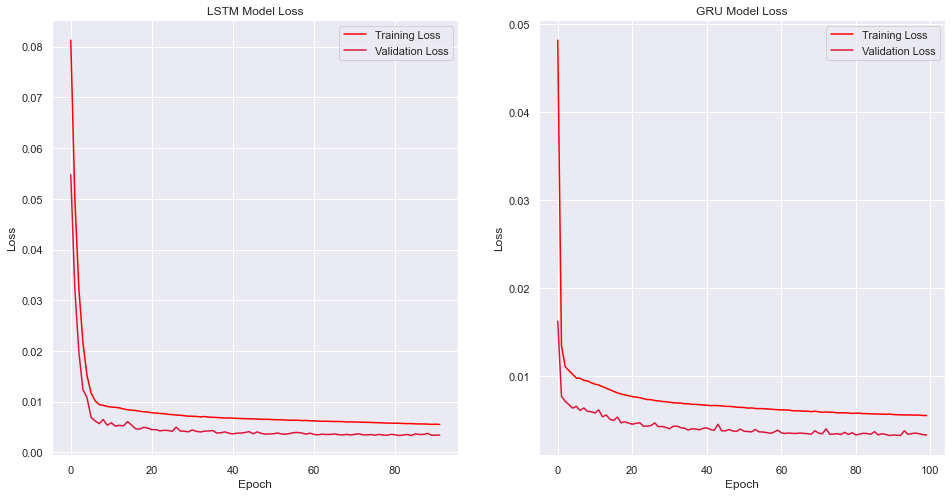

In [84]:

# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='crimson')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='crimson')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig("images/training_loss.png", dpi=1200)
plt.show()

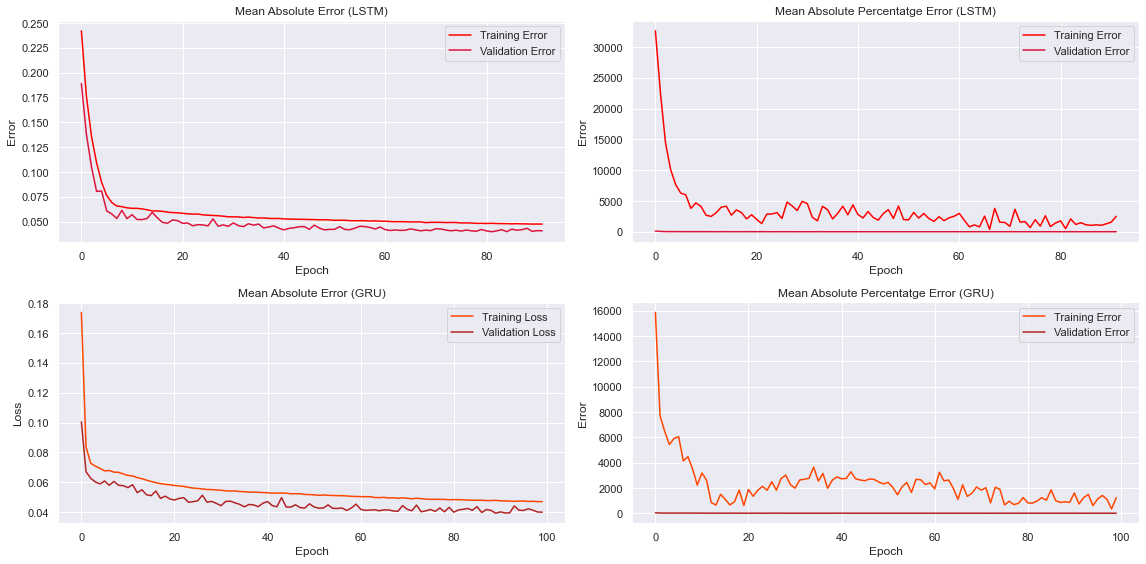

In [85]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(16,8))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='crimson')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='crimson')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig("images/mean_absolute_error_loss.png", dpi=1200)
plt.show()

In [86]:
from tensorflow.keras.models import load_model
lstm_model = load_model('model/model_lstm/')
gru_model = load_model('model/model_gru/')

In [87]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

238/238 [==============================] - 3s 7ms/step


In [88]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [89]:
(lstm_evaluation, gru_evaluation)

([0.004264821298420429, 0.04327711462974548, 10537.2890625],
 [0.004081164486706257, 0.04239740967750549, 2891.158447265625])

In [102]:
print(f'LSTM: Loss: {np.round(lstm_evaluation[0],4)}, Mean Absolute Error: {np.round(lstm_evaluation[1],4)}, MAPE: {np.round(lstm_evaluation[2],4)}')
print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')

LSTM: Loss: 0.0043, Mean Absolute Error: 0.0433, MAPE: 10537.2891
GRU: Loss: 0.0041, Mean Absolute Error: 0.0424, MAPE: 2891.1584


In [90]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [91]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [92]:
lstm_Y_pred = lstm_y_inverse[:, 7]
gru_Y_pred = gru_y_inverse[:,7]
actual_Y_test = Y_Test_transfer[:, 7]

In [93]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()

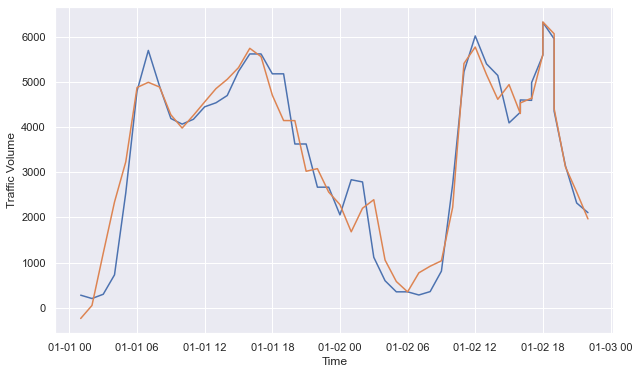

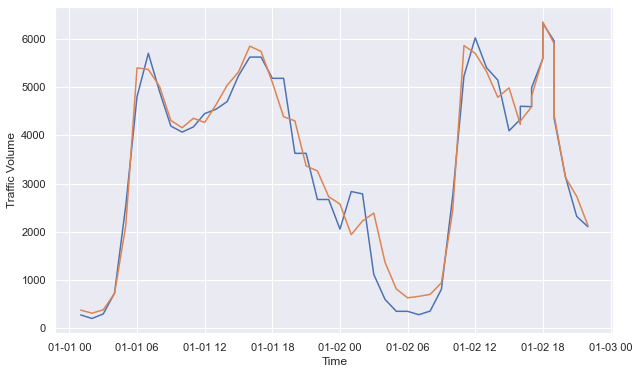

In [94]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_data['ds'])

plt.figure(figsize=(10,6))
plot_series(time_test[:50], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(10,6))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [95]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Traffic Volume')
    ax.grid(True)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


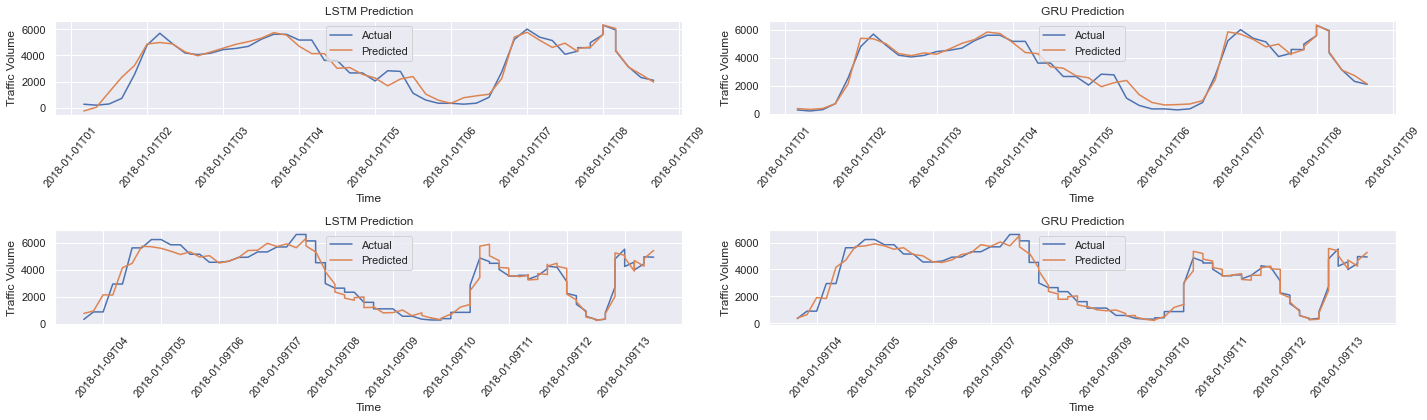

In [96]:
fig, ax = plt.subplots(2,2, figsize=(20,6))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(10,6))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("images/prediction_1.png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


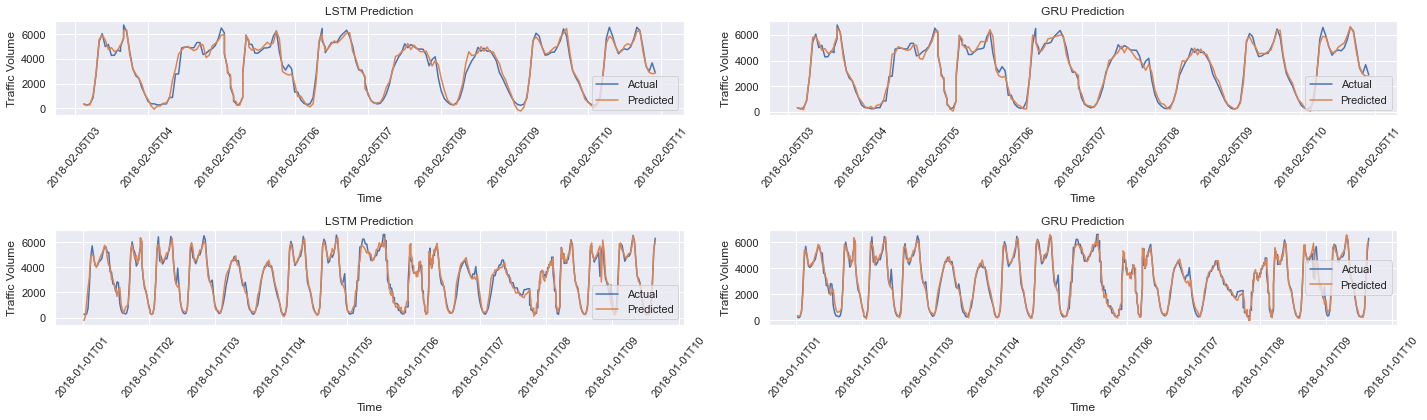

In [97]:
fig, ax = plt.subplots(2,2, figsize=(20,6))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("images/prediction_1.png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


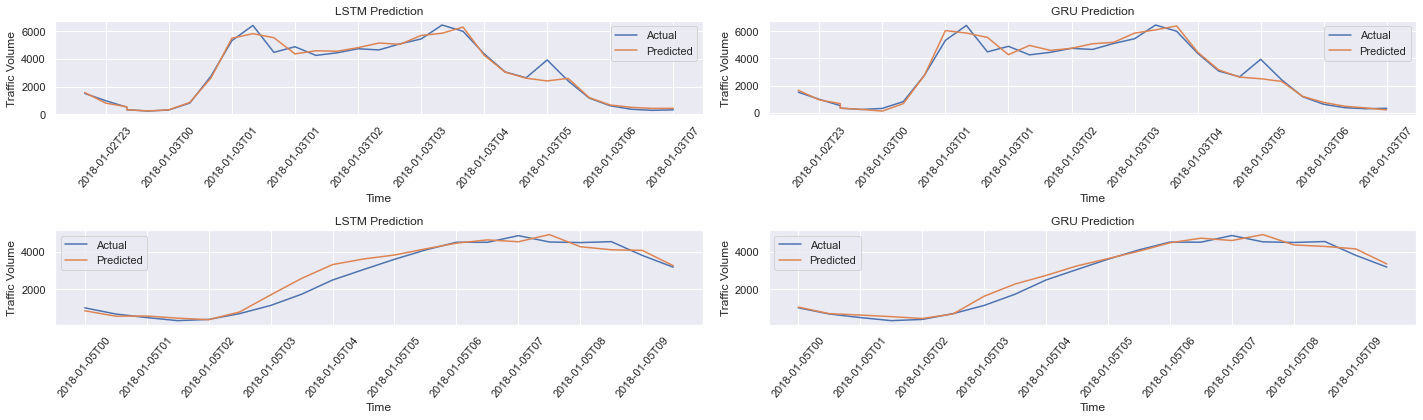

In [99]:
fig, ax = plt.subplots(2,2, figsize=(20,6))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("images/prediction_2.png", dpi=1200)

C:\Users\Won's Lab\AppData\Local\Temp\ipykernel_19364\2374997822.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=50)


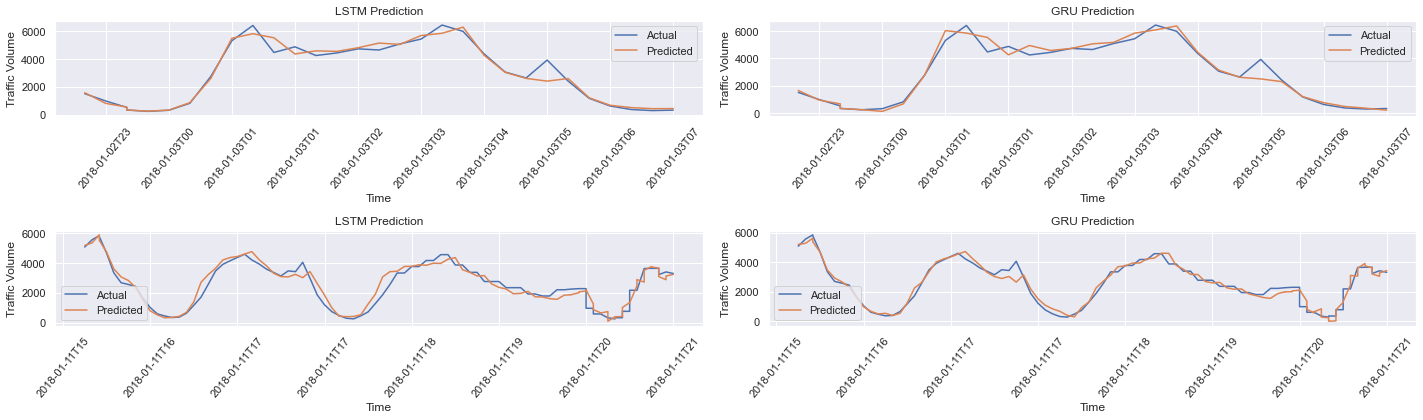

In [100]:
fig, ax = plt.subplots(2,2, figsize=(20,6))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig("images/prediction_2.png", dpi=1200)